<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1.-早期停止法" data-toc-modified-id="1.-早期停止法-1">1. 早期停止法</a></span><ul class="toc-item"><li><span><a href="#1.1-Python-实现" data-toc-modified-id="1.1-Python-实现-1.1">1.1 Python 实现</a></span></li></ul></li><li><span><a href="#参考文献" data-toc-modified-id="参考文献-2">参考文献</a></span></li></ul></div>

相关文章：

[机器学习 | 目录](https://blog.csdn.net/weixin_45488228/article/details/99691709)

[机器学习 | 梯度下降原理及Python实现](https://blog.csdn.net/weixin_45488228/article/details/99506171)

# 1. 早期停止法

对于[梯度下降](https://blog.csdn.net/weixin_45488228/article/details/99506171)这一类迭代学习的算法，还有一个与众不同的正则化方法，就是在验证误差达到最小值时停止训练，该方法叫作`早期停止法`。下图展现了一个用批量梯度下降训练的复杂模型（高阶多项式回归模型）。经过一轮一轮的训练，算法不断地学习，训练集上的预测误差（RMSE）自然不断下降，同样其在验证集上的预测误差也随之下降。但是，一段时间之后，验证误差停止下降反而开始上升。这说明模型开始过度拟合训练数据。通过早期停止法，一旦验证误差达到最小值就立刻停止训练。这是一个非常简单而有效的正则化技巧。<sup>[1]

> 对随机梯度下降和小批量梯度下降来说，曲线没有那么平滑，所以很难知道是否已经达到最小值。一种解决办法是等验证误差超过最小值一段时间之后再停止（这时你可以确信模型不会变得更好了），然后将模型参数回滚到验证误差最小时的位置。

<center> 图1 早期停止法正则化</center>

## 1.1 Python 实现

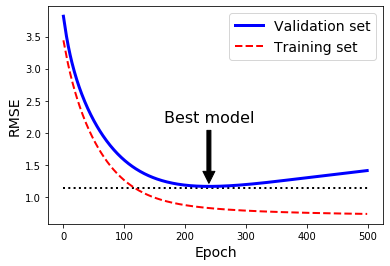

In [13]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler()),
    ])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=1,
                       tol=-np.infty,
                       penalty=None,
                       eta0=0.0005,
                       warm_start=True,                       # 当 warm_start=True 时，调用 fit() 方法，会从停下的地方继续
                                                              # 开始训练，而不会重新开始
                       learning_rate="constant",
                       random_state=42)

from sklearn.metrics import mean_squared_error
n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

# 画箭头
plt.annotate('Best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

best_val_rmse -= 0.03  # just to make the graph look better
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.show()

# 参考文献

[1] Aurelien Geron, 王静源, 贾玮, 边蕤, 邱俊涛. 机器学习实战：基于 Scikit-Learn 和 TensorFlow[M]. 北京: 机械工业出版社, 2018: 125-126.